# Time-Series Analysis using PyCaret: Prothom Alo

## Highlights

* PyCaret Time-Series Problem

### Dataset: Prothom Alo 2021 Dataset. 

* Training Period: 2021-04-24 to 2021-06-19 
* Test/Validation Period: 2021-06-20 to 2021-06-27

Author: Sumaia Parveen Shupti

Created on: 07/09/2021

Updated on: 07/10/2021

## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

## Install PyCaret

In [2]:
#!pip install pycaret-ts-alpha

## Load & Clean Prothom Alo 2021 Dataset

In [3]:
df1 = pd.read_csv('../input/prothom-alo-20192021/prothom_alo_2021.csv')
df1 = df1[['date_of_incident', 'time_of_incident', 'published-time',
       'incident_type', 'location', 'death_count', 'injury_count',
       'type_of_vehicle1', 'type_of_vehicle2']]

df1.loc[1, 'time_of_incident'] = '20:00'
df1["time_of_incident"] = pd.to_datetime(df1["time_of_incident"], format='%H:%M').dt.time

df1['date_of_incident'] = pd.to_datetime(df1['date_of_incident'])
df1 = df1.reset_index(drop = True).set_index('date_of_incident').resample('1D').sum().reset_index()
df_2021 = df1.copy()
df_2021

,date_of_incident,death_count,injury_count
0,2021-01-01,4.0,1.0
1,2021-01-02,0.0,0.0
2,2021-01-03,7.0,0.0
3,2021-01-04,0.0,0.0
4,2021-01-05,0.0,0.0
...,...,...,...
173,2021-06-23,3.0,0.0
174,2021-06-24,2.0,0.0
175,2021-06-25,0.0,2.0
176,2021-06-26,2.0,2.0


## Feature Engineering

In [4]:
df_2021['Date'] = df_2021['date_of_incident'].dt.date
df_2021['Year'] = df_2021['date_of_incident'].dt.year
df_2021['Month'] = df_2021['date_of_incident'].dt.month
df_2021['Day'] = df_2021['date_of_incident'].dt.day
df_2021['Day_name'] = df_2021['date_of_incident'].dt.day_name()
df_2021['DayofWeek'] = df_2021['date_of_incident'].dt.weekday
df_2021['Weekend_(y/n)'] = ((df_2021['date_of_incident'].dt.dayofweek) // 5 == 1).astype(float)
df_2021['DayofYear'] = df_2021['date_of_incident'].dt.dayofyear
# Convert the date into a number (of days since some point)
fromDate = min(df_2021['date_of_incident'])
df_2021['DateInt'] = (df_2021['date_of_incident'] - fromDate).astype(np.int64)/100000000000
df_2021.head()

,date_of_incident,death_count,injury_count,Date,Year,Month,Day,Day_name,DayofWeek,Weekend_(y/n),DayofYear,DateInt
0,2021-01-01,4.0,1.0,2021-01-01,2021,1,1,Friday,4,0.0,1,0.0
1,2021-01-02,0.0,0.0,2021-01-02,2021,1,2,Saturday,5,1.0,2,864.0
2,2021-01-03,7.0,0.0,2021-01-03,2021,1,3,Sunday,6,1.0,3,1728.0
3,2021-01-04,0.0,0.0,2021-01-04,2021,1,4,Monday,0,0.0,4,2592.0
4,2021-01-05,0.0,0.0,2021-01-05,2021,1,5,Tuesday,1,0.0,5,3456.0


Taking the below columns for the Regression and Time-Series Problem.

In [5]:
df_2021 = df_2021[[ 'Date', 'Year', 'Month', 'Day', 'DayofWeek', 'Weekend_(y/n)', 'DayofYear', 'DateInt', 'death_count']]
df_2021.head()

,Date,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,death_count
0,2021-01-01,2021,1,1,4,0.0,1,0.0,4.0
1,2021-01-02,2021,1,2,5,1.0,2,864.0,0.0
2,2021-01-03,2021,1,3,6,1.0,3,1728.0,7.0
3,2021-01-04,2021,1,4,0,0.0,4,2592.0,0.0
4,2021-01-05,2021,1,5,1,0.0,5,3456.0,0.0


## Train Test Split

* Test/Validation data = 7 days data
* Training data =  8 weeks data

In [6]:
start_ = df_2021.Date.max()
end_ = df_2021.Date.min()

test_end = df_2021.Date.max()
test_start = df_2021.Date.max() - timedelta(days = 7)

train_end = test_start - timedelta(days = 1)
train_start = train_end - timedelta(days = 56)

print('Dataset Start Date: {}'.format(start_))
print('Dataset End Date: {}'.format(end_))
print (' ')
print('Train Set Start Date: {}'.format(train_start))
print('Train Set End Date: {}'.format(train_end))
print (' ')
print('Test Set Start Date: {}'.format(test_start))
print('Test Set End Date: {}'.format(test_end))
print (' ')

Dataset Start Date: 2021-06-27
Dataset End Date: 2021-01-01
 
Train Set Start Date: 2021-04-24
Train Set End Date: 2021-06-19
 
Test Set Start Date: 2021-06-20
Test Set End Date: 2021-06-27
 


In [7]:
mask = (df_2021.Date >= train_start) & (df_2021.Date <= train_end)
train = df_2021.loc[mask]
train = train.drop('Date', 1)

mask = (df_2021.Date >= test_start) & (df_2021.Date <= test_end)
test = df_2021.loc[mask]
test = test.drop('Date', 1)

In [8]:
train.tail()

,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,death_count
165,2021,6,15,1,0.0,166,142560.0,0.0
166,2021,6,16,2,0.0,167,143424.0,0.0
167,2021,6,17,3,0.0,168,144288.0,0.0
168,2021,6,18,4,0.0,169,145152.0,15.0
169,2021,6,19,5,1.0,170,146016.0,10.0


In [9]:
test.head()

,Year,Month,Day,DayofWeek,Weekend_(y/n),DayofYear,DateInt,death_count
170,2021,6,20,6,1.0,171,146880.0,2.0
171,2021,6,21,0,0.0,172,147744.0,0.0
172,2021,6,22,1,0.0,173,148608.0,1.0
173,2021,6,23,2,0.0,174,149472.0,3.0
174,2021,6,24,3,0.0,175,150336.0,2.0


## PyCaret Time Series Analysis

### Import libraries

In [10]:
from pprint import pprint
from pycaret.datasets import get_data
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment

from sktime.utils.plotting import plot_series

### Loading Dataset

In [11]:
df_2021['Date'] = pd.to_datetime(df_2021['Date'])
df = df_2021.set_index('Date')
y = df.death_count
y

Date
2021-01-01     4.0
2021-01-02     0.0
2021-01-03     7.0
2021-01-04     0.0
2021-01-05     0.0
2021-01-06     0.0
2021-01-07     0.0
2021-01-08     0.0
2021-01-09     0.0
2021-01-10     0.0
2021-01-11     0.0
2021-01-12     0.0
2021-01-13     0.0
2021-01-14     0.0
2021-01-15     0.0
2021-01-16     0.0
2021-01-17     0.0
2021-01-18     2.0
2021-01-19     0.0
2021-01-20     0.0
2021-01-21     4.0
2021-01-22     0.0
2021-01-23     1.0
2021-01-24     0.0
2021-01-25     2.0
2021-01-26     0.0
2021-01-27     0.0
2021-01-28     0.0
2021-01-29     0.0
2021-01-30     0.0
2021-01-31     4.0
2021-02-01     1.0
2021-02-02     0.0
2021-02-03     2.0
2021-02-04     0.0
2021-02-05     0.0
2021-02-06     1.0
2021-02-07     0.0
2021-02-08     2.0
2021-02-09     0.0
2021-02-10     9.0
2021-02-11     3.0
2021-02-12     2.0
2021-02-13     0.0
2021-02-14     2.0
2021-02-15     1.0
2021-02-16     0.0
2021-02-17     0.0
2021-02-18     0.0
2021-02-19     0.0
2021-02-20     6.0
2021-02-21     0.0
2021-02

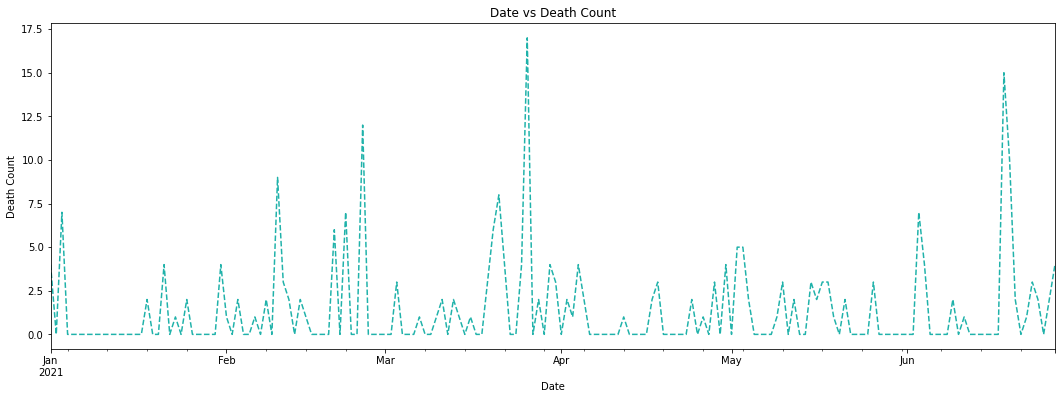

In [12]:
plt.figure(figsize=(18, 6))
y.plot(color = 'lightseagreen', linestyle = '--')
plt.title('Date vs Death Count')
plt.ylabel('Death Count')
plt.show()

### Setup PyCaret Time Series Experiment

In [13]:
exp = TimeSeriesExperiment()
exp.setup(data=y, fh=7, fold=3, session_id=42)

,Description,Value
0,session_id,42
1,Original Data,"(178, 1)"
2,Missing Values,False
3,Transformed Train Set,"(171,)"
4,Transformed Test Set,"(7,)"
5,Fold Generator,ExpandingWindowSplitter
6,Fold Number,3
7,CPU Jobs,-1
8,Use GPU,False
9,Log Experiment,False


### List of Available Models

In [14]:
exp.models()

,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
polytrend,Polynomial Trend Forecaster,sktime.forecasting.trend.PolynomialTrendForeca...,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
exp_smooth,Exponential Smoothing,sktime.forecasting.exp_smoothing.ExponentialSm...,True
ets,ETS,sktime.forecasting.ets.AutoETS,True
theta,Theta Forecaster,sktime.forecasting.theta.ThetaForecaster,True
tbats,TBATS,sktime.forecasting.tbats.TBATS,False


### Compare Different Models

In [15]:
%%time
best_baseline_models = exp.compare_models(n_select=3, sort='mape')

,Model,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
naive,Naive Forecaster,1.9524,19.0000,0.3333,2.0000,-0.3905,1.1533
snaive,Seasonal Naive Forecaster,1.9524,19.0000,0.3333,2.0000,-0.3905,0.0133
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,2.1728,17.5766,1716783162647466.0000,1.8215,-0.3277,0.0467
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,2.3795,16.7164,3091142506256888.0000,1.7599,-0.5459,0.2800
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,2.4726,16.8505,3484076744032346.5000,1.7805,-0.6047,0.0500
catboost_cds_dt,CatBoost Regressor w/ Cond. Deseasonalize & Detrending,2.4177,16.7384,3515183299454794.0000,1.7065,-0.8834,1.5067
arima,ARIMA,2.3991,15.6360,3812326350049344.5000,1.6556,-0.5319,0.0900
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,2.4566,16.4528,3870947672672687.5000,1.6802,-0.9347,0.3800
auto_arima,Auto ARIMA,2.4132,15.6728,3874918526233050.5000,1.6557,-0.5567,0.2233
theta,Theta Forecaster,2.4470,15.7538,4046713566167956.0000,1.6536,-0.6754,0.0200


CPU times: user 15.8 s, sys: 518 ms, total: 16.3 s
Wall time: 1min 18s


## Reference

* https://nbviewer.jupyter.org/github/pycaret/sktime-dev-days-2021/blob/main/sktime_dev_days_101.ipynb